<a href="https://colab.research.google.com/github/gonzalezjulvez/Projects/blob/main/Formacion/Regresion_Basica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresion Basica: Predecir eficiencia de gasolina

En un problema de regresion, buscamos predecir la salida de un valor continuo como la probabilidad de un precio. En contraste en un problema de Clasificacion, buscamos seleccionar una clase de una lista de clases (por ejemplo, en donde una imagen contenga una manzana o una naranja queremos reconocer cual es la fruta en la imagen).

Este libro usa el set de datos clasico Auto MPG y construye un modelo para predecir la eficiencia de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.



## Importar librerias

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


## Obtener Datos

El set de datos esta disponible de el siguiente repositorio UCI Machine Learning Repository.

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

datasets_path = tf.keras.utils.get_file('auto-mpg',url)

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(datasets_path, names=column_names,sep=" ",na_values = "?", comment='\t',skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()

## Limpieza de datos

In [5]:
dataset.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
# Mantener este tutorial inicial sencillo eliminemos las siguientes filas
dataset = dataset.dropna()

In [7]:
# La columna de "Origin" realmente es categorica, no numerica. Entonces conviertala a un "one-hot":

origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspeccionar los datos

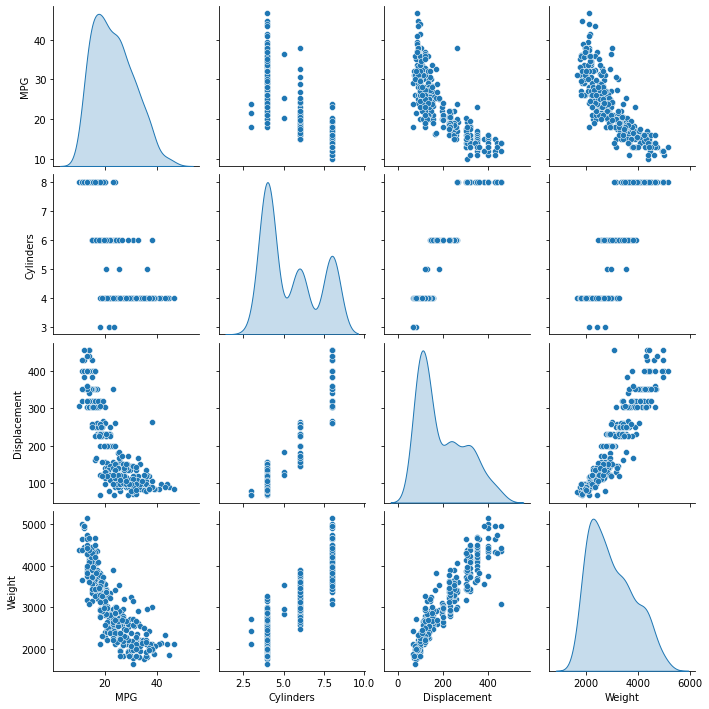

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [11]:
# Separamos las caracteristicas de las etiquetas

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')


In [12]:
# Normalizamos los datos

def norm(x):
  return (x - train_stats['mean'])/ train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## El modelo

In [16]:
# Construimos el modelo

def build_model():
  model = keras.Sequential([
                            layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae','mse'])
  return model               

In [17]:
model = build_model()

In [18]:
# inspeccionamos el modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.3218769 ],
       [-0.10285756],
       [-1.0576946 ],
       [-0.38859448],
       [-0.42520297],
       [-0.24253531],
       [-0.49519742],
       [-0.57094574],
       [-0.32376075],
       [-0.38376182]], dtype=float32)

In [20]:
# Entrenamos el modelo
epochs = 1000
history = model.fit(normed_train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=1)

Epoch 1/1000
8/8 [==============================] - 1s 89ms/step - loss: 611.3184 - mae: 23.4547 - mse: 611.3184 - val_loss: 591.6169 - val_mae: 23.0650 - val_mse: 591.6169
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 556.1985 - mae: 22.3388 - mse: 556.1985 - val_loss: 549.8986 - val_mae: 22.0930 - val_mse: 549.8986
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 531.0215 - mae: 21.6965 - mse: 531.0215 - val_loss: 506.0029 - val_mae: 21.0528 - val_mse: 506.0029
Epoch 4/1000
8/8 [==============================] - 0s 7ms/step - loss: 443.5725 - mae: 19.6398 - mse: 443.5725 - val_loss: 457.7190 - val_mae: 19.8675 - val_mse: 457.7190
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 423.7417 - mae: 19.1068 - mse: 423.7417 - val_loss: 406.4038 - val_mae: 18.5275 - val_mse: 406.4038
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 388.9668 - mae: 18.1439 - mse: 388.9668 - val_loss: 352.7786 - val_

In [22]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Abs Error [MPG]")
  plt.plot(hist['epoch'],hist['mae'],label='Train Error')
  plt.plot(hist['epoch'],hist['val_mae'],label='Validation Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

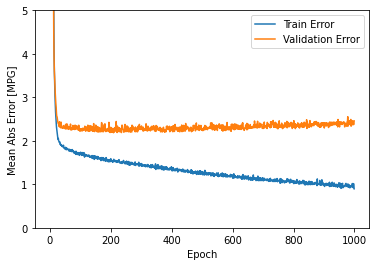

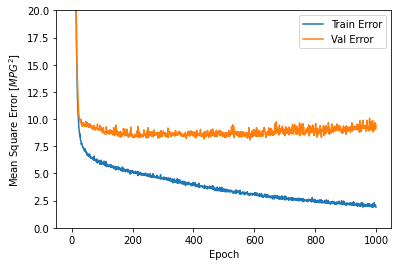

In [23]:
plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. Actualicemos la llamada model.fit para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una * devolución de llamada de EarlyStopping * que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.



In [24]:
model = build_model()
epochs=1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(normed_train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=2, callbacks=[early_stop])


Epoch 1/1000
8/8 - 1s - loss: 538.0078 - mae: 21.9050 - mse: 538.0078 - val_loss: 516.4637 - val_mae: 21.4069 - val_mse: 516.4637
Epoch 2/1000
8/8 - 0s - loss: 472.8676 - mae: 20.4192 - mse: 472.8676 - val_loss: 447.7190 - val_mae: 19.7919 - val_mse: 447.7190
Epoch 3/1000
8/8 - 0s - loss: 408.4053 - mae: 18.8490 - mse: 408.4053 - val_loss: 374.5921 - val_mae: 17.9598 - val_mse: 374.5921
Epoch 4/1000
8/8 - 0s - loss: 341.1064 - mae: 17.0673 - mse: 341.1064 - val_loss: 301.6643 - val_mae: 15.9042 - val_mse: 301.6643
Epoch 5/1000
8/8 - 0s - loss: 273.5172 - mae: 15.0829 - mse: 273.5172 - val_loss: 230.0067 - val_mae: 13.5867 - val_mse: 230.0067
Epoch 6/1000
8/8 - 0s - loss: 209.6427 - mae: 12.8931 - mse: 209.6427 - val_loss: 167.2407 - val_mae: 11.2586 - val_mse: 167.2407
Epoch 7/1000
8/8 - 0s - loss: 154.0564 - mae: 10.7439 - mse: 154.0564 - val_loss: 116.1997 - val_mae: 9.1162 - val_mse: 116.1997
Epoch 8/1000
8/8 - 0s - loss: 109.6752 - mae: 8.6722 - mse: 109.6752 - val_loss: 79.6606 - 

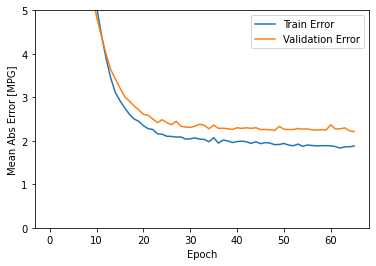

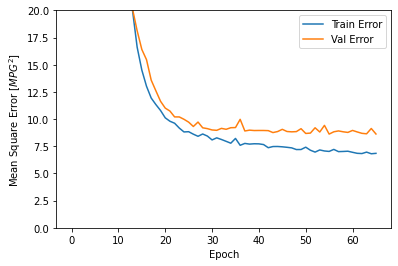

In [25]:
plot_history(history)

In [26]:
# Evaluamos el modelo

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


3/3 - 0s - loss: 6.3654 - mae: 1.9601 - mse: 6.3654
Testing set Mean Abs Error:  1.96 MPG


## Usamos el modelo

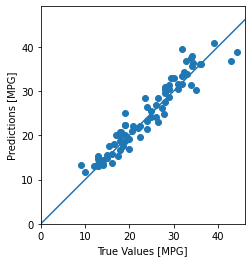

In [27]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


(array([ 1.,  1.,  1.,  0.,  1.,  1.,  4.,  3.,  1.,  4., 10.,  6.,  9.,
         3., 11.,  7.,  4.,  5.,  2.,  1.,  1.,  0.,  1.,  0.,  1.]),
 array([-6.34184418, -5.78841257, -5.23498096, -4.68154935, -4.12811774,
        -3.57468613, -3.02125452, -2.46782291, -1.9143913 , -1.36095969,
        -0.80752808, -0.25409647,  0.29933514,  0.85276675,  1.40619836,
         1.95962997,  2.51306158,  3.06649319,  3.6199248 ,  4.17335641,
         4.72678802,  5.28021964,  5.83365125,  6.38708286,  6.94051447,
         7.49394608]),
 <a list of 25 Patch objects>)

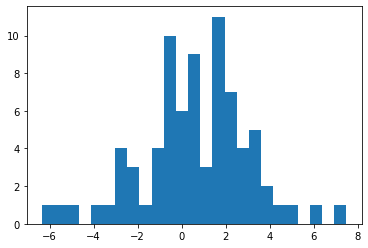

In [29]:
errors = test_predictions - test_labels
plt.hist(errors, bins=25)


Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

- El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
- Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
- Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
- Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
- La detención temprana es una técnica útil para evitar el sobreajuste.